## МОДУЛЬ ПРЕДНАЗНАЧЕН ДЛЯ ФОРМИРОВАНИЯ 2D ГРАФИКОВ С СДАННЫМИ ПОСТУПАЮЩИМИ С МИКРОСХЕМЫ СЕНСОРА - ГИРОСКОПА, АКСЕЛЕРОМЕТРА, МАГНИТОМЕТРА
---

### Блок импорта библиотек необходимых для работы с 2D графиками

In [1]:
# Подключить библиотеки для мат обработки данных и генерации случайных данных
import numpy as np
import random
import math
# Подключить библиотеки для работы с 2D графиками и анимации
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, NullFormatter
import matplotlib.animation as an
from IPython.display import display, clear_output
# Подключить библиотеки для работы с датой/временем
from datetime import datetime
import time
# Подключить библиотеки для асинхронной работы
import asyncio

### Блок настроек среды исполнения Jupyter lab

In [2]:
%matplotlib  widget
#%matplotlib  inline

### Блок разработки функции создания фигуры в терминологии Matplotlib

In [3]:
'''
Класс SetInterval реализует асинхронную модель работы метода 'run' аналогично
функции setInterval в JavaScript
'''
class SetInterval:
    def __init__(self, interval, fn):
        self.interval = interval        # интервал вызова пользовательской функции 'fn'
        self.fn = fn                    # пользовательский метод который будет асинхронно вызываться с заданным периодом
        self.is_running = False         # идет выполнение 'run'
        self.task = None
        self.last_execution_time = None # вспомогательное поле для определения истинного времени между вызовами, отладочный код 

    '''
    Метод 'run' является основным в реализации идеологии SetInterval, в нем происходит запуск 
    пользовательской функции 'fn'
    '''
    async def run(self):
        self.is_running = True
        while self.is_running:
            self.calculate_elapsed_time()
            self.fn()
            await asyncio.sleep(self.interval)
    
    '''
    Метод 'calculate_elapsed_time' вспомогательный отладочный метод, предназначенный для 
    вычисления времени между двумя вызовами основного метода 'run' в котором происходит
    запуск пользовательского метода 'fn'.
    Данный метод после отладки кода можно отключить, т.к. он только добавляет небольшую
    трату вычислительных ресурсов.
    '''
    def calculate_elapsed_time(self):
        current_time = time.time()
        if self.last_execution_time is not None:
            elapsed_time = current_time - self.last_execution_time
            temp_delta = int(elapsed_time * 100000) / 100
            print(f"Delta time Python: {temp_delta} ms")
            
        self.last_execution_time = current_time
    
    '''
    Метод 'start' относится к сервисным, он непосредственно создает 'task' в терминологии
    библиотеки 'asyncio' Python в который на запуск передается метод 'run', который фактически
    вызывает запуск пользовательской функции 'fn'
    '''
    def start(self):
        self.task = asyncio.create_task(self.run())
    
    '''
    Метод 'stop' прекращает работу всей механики данного класса, фактически данный метод 
    аналогичен методу 'clearInterval' в JavaScript для 'setInterval'
    '''
    def stop(self):
        self.is_running = False

In [4]:
class Grafics2D:
    # Аргументы конструктора:
    # _opts  - словарь содержащий следующие значения:
    #               -> figsize    - размер фигуры в дюймах, кортеж из двух значений типа *int*
    #               -> nrows      - количество осей (графиков) по вертикали, значение типа *int*
    #               -> suptitle   - подпись ко всей группе графиков в целом (к фигуре), тип *string*
    #               -> abscissa   - подпись к оси абсцисс (ось X), такая подпись одна (!), относится к фигуре в целом, тип *string*
    #               -> ordinate   - подпись к осям ординат (оси Y), кортеж типа *string*
    #               -> facecolor  - цет заливки фона графика, кортеж типа *string*
    #               -> alpha      - прозрачность цвета заливки графика, кортеж типа *int*
    #               -> graphcolor - цвет кривой графика, кортеж типа *string*
    #               -> xlim       - диапазон значений оси X Xmim, Xmax, кортеж из двух значений типа *int*
    #               -> ylim       - диапазон значений оси Y Ymim, Ymax, кортеж из двух значений типа *int*
    
    def __init__( self, _opts ):

        self.FigureOpt  = _opts            # поле хранит набор характеристик фигуры которую необходимо сгенерировать
        
        self.ValueLim   = _opts['xlim'][1] # количество значений сенсора хранящихся в массиве
        self.IterNumber = 0                # поле хранит номер измерения, которое может быть целым числом в диапазоне 0...360

        # заполнить '0' значениями массив отображаемых на графиках данных
        self.Gyro  = [ [0] * self.ValueLim, [0] * self.ValueLim, [0] * self.ValueLim ]
        self.Acc   = [ [0] * self.ValueLim, [0] * self.ValueLim, [0] * self.ValueLim ]
        self.Mag   = [ [0] * self.ValueLim, [0] * self.ValueLim, [0] * self.ValueLim]

        self.X      = np.arange( self.ValueLim )     # набор целых чисел, являющиеся отсчетами оси Х
        
        self.Figure = None                    # хранит сгенерированную 'figure'
        self.Ax     = None                    # хранит сгенерированную 'axes'
        self.Lines  = []                      # хранит собственно 'кривые' графиков

    # Метод CreateVectorFigure на основе значения аргументов словаря 'FigureOpt', в соответствии ними возвращает фигуру с созданными
    # и настроенными графиками. Особенность функции - она специфичным способом компонует графики:
    #               ВСЕ ГРАФИКИ БУДУТ ВЫСТРОЕНЫ В ОДИН ВЕРТИКАЛЬНЫЙ СТОЛБЕЦ, ПО ОДНОМУ ГРАФИКУ В СТРОКЕ
    #
    # Возвращаемое значение:
    #
    # figure    - созданная функцией фигура
    # ax        - созданные "оси" (суб-графики) в данной фигуре
    #
    def CreateVectorFigure( self ):
        self.Figure = plt.figure( figsize = self.FigureOpt['figsize'] ) # создать фигуру
        self.Ax = self.Figure.subplots( self.FigureOpt['nrows'], 1 )    # создать заданное количество осей Axes (графиков)
        
        # Сохранить 'кривые' графиков в мпссив
        for i in range(self.FigureOpt['nrows']):
            line, = self.Ax[i].plot(self.X, self.Acc[i])  
            self.Lines.append(line)
    
        self.StartPropertyAxes() # задать характеристики отображения регионов построения графиков и собственно графиков
    
    # Метод StartPropertyAxes принимает ряд аргументов и в соответствии с ними задает 
    # ряд свойств области графика (не figure!) на этапе создания 'figure'. Данная функция
    # предназначена только для задания стартовых свойств Axes ! Для задания свойств во время 
    # модификации необходимо использовать другой метод.
    # Аргументы:
    # _opts     - словарь содержащий следующие значения:
    #               -> figure     - фигура (API matplotlib)
    #               -> ax         - оси Axes переданной фигуры (API matlotlib)
    #               -> suptitle   - подпись ко всей группе графиков в целом (к фигуре), тип *string*
    #               -> abscissa   - подпись к оси абсцисс (ось X), такая подпись одна (!), относится к фигуре в целом, тип *string*
    #               -> ordinate   - подпись к осям ординат (оси Y), кортеж типа *string*
    #               -> facecolor  - цет заливки фона графика, кортеж типа *string*
    #               -> alpha      - прозрачность цвета заливки графика, кортеж типа *int*
    #               -> graphcolor - цвет кривой графика, кортеж типа *string*
    #               -> xlim       - диапазон значений оси X Xmim, Xmax, кортеж из двух значений типа *int*
    #               -> ylim       - диапазон значений оси Y Ymim, Ymax, кортеж из двух значений типа *int*

    def StartPropertyAxes( self ):
        
        self.Figure.suptitle( self.FigureOpt['suptitle'] ) # задать подпись к фигуре в целом
        _ax = self.Ax # создать временную локальную переменную
    
        # задать свойства осей и полигонов всех графиков
        for i in np.arange( self.FigureOpt['nrows'] ):
            _ax[i].set_ylabel( self.FigureOpt['ordinate'][i] , fontweight='bold' ) # задать жирное начертание для подписи к Y осям
            _ax[i].yaxis.get_label().set_rotation(0)                               # задать вращение подписей Y осей
        
            # задать подпись к единственной, последней оси абсцисс (ось Х), она одна для всех графиков
            _ax[i].set_xlabel( self.FigureOpt['abscissa'], fontweight='bold' ) if i == self.FigureOpt['nrows']-1 else None  
        
            # задать характеристики графика
            rect = _ax[i].patch                                  # добавить объект-фигуру в 'rect'
            rect.set_facecolor( self.FigureOpt['facecolor'][i] ) # задать цвет заливки фона графика
            rect.set_alpha( self.FigureOpt['alpha'][i] )         # задать прозрачность заливки фона графика    
        
            # Задание минимального и максимального значения для оси X
            _ax[i].set_xlim( self.FigureOpt['xlim'][0], self.FigureOpt['xlim'][1] )
            # Задание минимального и максимального значения для оси Y
            _ax[i].set_ylim( self.FigureOpt['ylim'][0], self.FigureOpt['ylim'][1] )


    '''
    Метод UpdatePropertyAxes обновляет  ряд свойств области графика (не фигуры!).
    Данная функция предназначена для вызова при обновлении данных графика.
    '''
    
    def UpdatePropertyAxes( self ):

        self.Figure.suptitle( self.FigureOpt['suptitle'] ) # задать подпись к фигуре в целом
        _ax = self.Ax                                      # создать временную локальную переменную
    
        # задать свойства осей и полигонов всех графиков
        for i in np.arange( self.FigureOpt['nrows'] ):
            #_ax[i].clear()
            #_ax[i].plot(self.X, self.Acc[i])
            self.Lines[i].set_data(self.X, self.Acc[i])
            
            _ax[i].set_ylabel( self.FigureOpt['ordinate'][i] , fontweight='bold' ) # задать жирное начертание для подписи к Y осям
            _ax[i].yaxis.get_label().set_rotation(0)                               # задать вращение подписей Y осей
        
            # задать подпись к единственной, последней оси абсцисс (ось Х), она одна для всех графиков
            _ax[i].set_xlabel( self.FigureOpt['abscissa'], fontweight='bold' ) if i == self.FigureOpt['nrows']-1 else None
        
            # задать характеристики графика
            rect = _ax[i].patch                                  # добавить объект-фигуру в 'rect'
            rect.set_facecolor( self.FigureOpt['facecolor'][i] ) # задать цвет заливки фона графика
            rect.set_alpha( self.FigureOpt['alpha'][i] )         # задать прозрачность заливки фона графика    
        
            _ax[i].lines[0].set_color( self.FigureOpt['graphcolor'][i] ) # задать цвет кривой графика
        
            # Задание минимального и максимального значения для оси X
            _ax[i].set_xlim( self.FigureOpt['xlim'][0], self.FigureOpt['xlim'][1] )
            # Задание минимального и максимального значения для оси Y
            _ax[i].set_ylim( self.FigureOpt['ylim'][0], self.FigureOpt['ylim'][1] )
        
            _ax[i].grid(True)
    
    #
    #
    #

    def UpdateDataIMU(self):
        data     = math.sin(math.radians( (self.IterNumber*360)/self.ValueLim )) # получить текущее значение sin(x)
        
        data_acc_x   = data + random.uniform(0, data*0.1) # подмешать 10% шумов
        data_acc_y   = data + random.uniform(0, data*0.1) # подмешать 10% шумов
        data_acc_z   = data + random.uniform(0, data*0.1) # подмешать 10% шумов

        self.Acc[0].append(data_acc_x)
        self.Acc[1].append(data_acc_y)
        self.Acc[2].append(data_acc_z)

        data_gyr_x = (data + random.uniform(0, data*0.1))*100  # масштабировать к 100 deg/s и подмешать 10% шумов
        data_gyr_y = (data + random.uniform(0, data*0.1))*100  # масштабировать к 100 deg/s и подмешать 10% шумов
        data_gyr_z = (data + random.uniform(0, data*0.1))*100  # масштабировать к 100 deg/s и подмешать 10% шумов

        self.Gyro[0].append(data_gyr_x)
        self.Gyro[1].append(data_gyr_y)
        self.Gyro[2].append(data_gyr_z)

        if len(self.Acc[0]) > self.ValueLim:
            self.Acc[0].pop(0)
            self.Acc[1].pop(0)
            self.Acc[2].pop(0)

            self.Gyro[0].pop(0)
            self.Gyro[1].pop(0)
            self.Gyro[2].pop(0)
        
        self.IterNumber += 1
        self.IterNumber = 1 if self.IterNumber > 360 else self.IterNumber # обнулить счетчик итераций если он стал > 360
    #
    #
    #
    def UpdateGraph( self, frame ):
        self.UpdateDataIMU()
        self.UpdatePropertyAxes()

### Далее идет блок кода который предназначен для демонстрации работы построителя графиков и отображения

In [5]:
# Создать объект 'options' для передачи в качестве аргумента в объект
options_2 = {
                'figsize': (8, 8),
                'nrows': 3,
                'suptitle': 'ГРАФИК ПОКАЗАНИЙ АКСЕЛЕРОМЕТРА',
                'abscissa': 'N',
                'ordinate': ('X', 'Y', 'Z'),
                'facecolor': ('lightslategray', 'lightslategray', 'lightslategray'),
                'alpha': (0.5, 0.5, 0.5),
                'graphcolor': ('green', 'blue', 'red'),
                'xlim': (0, 50),
                'ylim': (-2, 2) }

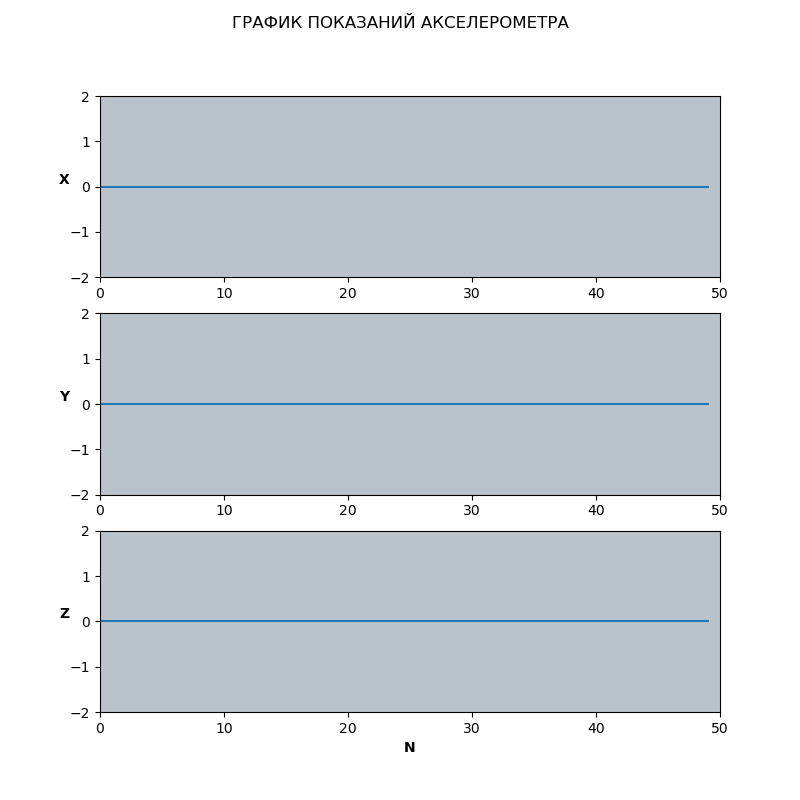

In [6]:
grafics_2D = Grafics2D( options_2 )
grafics_2D.CreateVectorFigure()


grafics_2D_anim = an.FuncAnimation(fig=grafics_2D.Figure, func=grafics_2D.UpdateGraph, interval=200, save_count=1500) # frames=50,
plt.show()
Codec = an.writers['ffmpeg']
VideoParam = Codec(fps=15, bitrate=1800) #metadata={'artist': 'Me'}

grafics_2D_anim.save('Line-Graph-Animation.mp4', VideoParam)

